## Generate CMIP Forcing data


In [41]:


# Ignore user warnings :)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Required dependencies
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print
import xarray as xr
import shutil
import matplotlib.pyplot as plt

import ewatercycle
import ewatercycle.forcing



In [42]:
# The name of the shapefile
shape_file_name = "AralSeaBasin"  # river: Bedford Ouse at Roxton, England

# The path to the shapefiles
shapefile_path =  Path.cwd()/'AralSea_Basin'/ f"{shape_file_name}.shp"  # check this directory yourself!

# The time-window of the experiment
experiment_start_date = "2030-01-01T00:00:00Z"
experiment_end_date = "2030-12-31T00:00:00Z"

# The path save directory of the CMIP data
forcing_path_CMIP = Path.cwd() / "forcing_CMIP_1010" / shape_file_name / "CMIP6"   # we do not use historical here, so we can use this as a default save path later on
forcing_path_CMIP.mkdir(parents=True, exist_ok=True)



In [43]:
Path.home()

PosixPath('/home/avandervee3')

In [44]:


cmip_historical =  {
   'project': 'CMIP6',
   'exp': 'historical',
   'dataset': 'MPI-ESM1-2-HR',
   "ensemble": 'r1i1p1f1',
   'grid': 'gn'
}

cmip_dataset =  {
    'project': 'CMIP6',
    'activity': 'ScenarioMIP',
    'exp': 'ssp585',
    'mip': 'day',
    'dataset': 'EC-Earth3',
    'ensemble': 'r1i1p1f1',
    'grid': '*'
}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=cmip_dataset,
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=shapefile_path,
   directory=forcing_path_CMIP / "future"/ "Lumped",
)



In [45]:
# Load the generated historical data
#historical_CMIP_location = forcing_path_CMIP / "historical" /"future"/ "work" / "diagnostic" / "script"
#historical_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=historical_CMIP_location)

#load the generated future data
future_CMIP_location = forcing_path_CMIP / "future"/ "Lumped" /"work" / "diagnostic" / "script"
future_CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=future_CMIP_location)

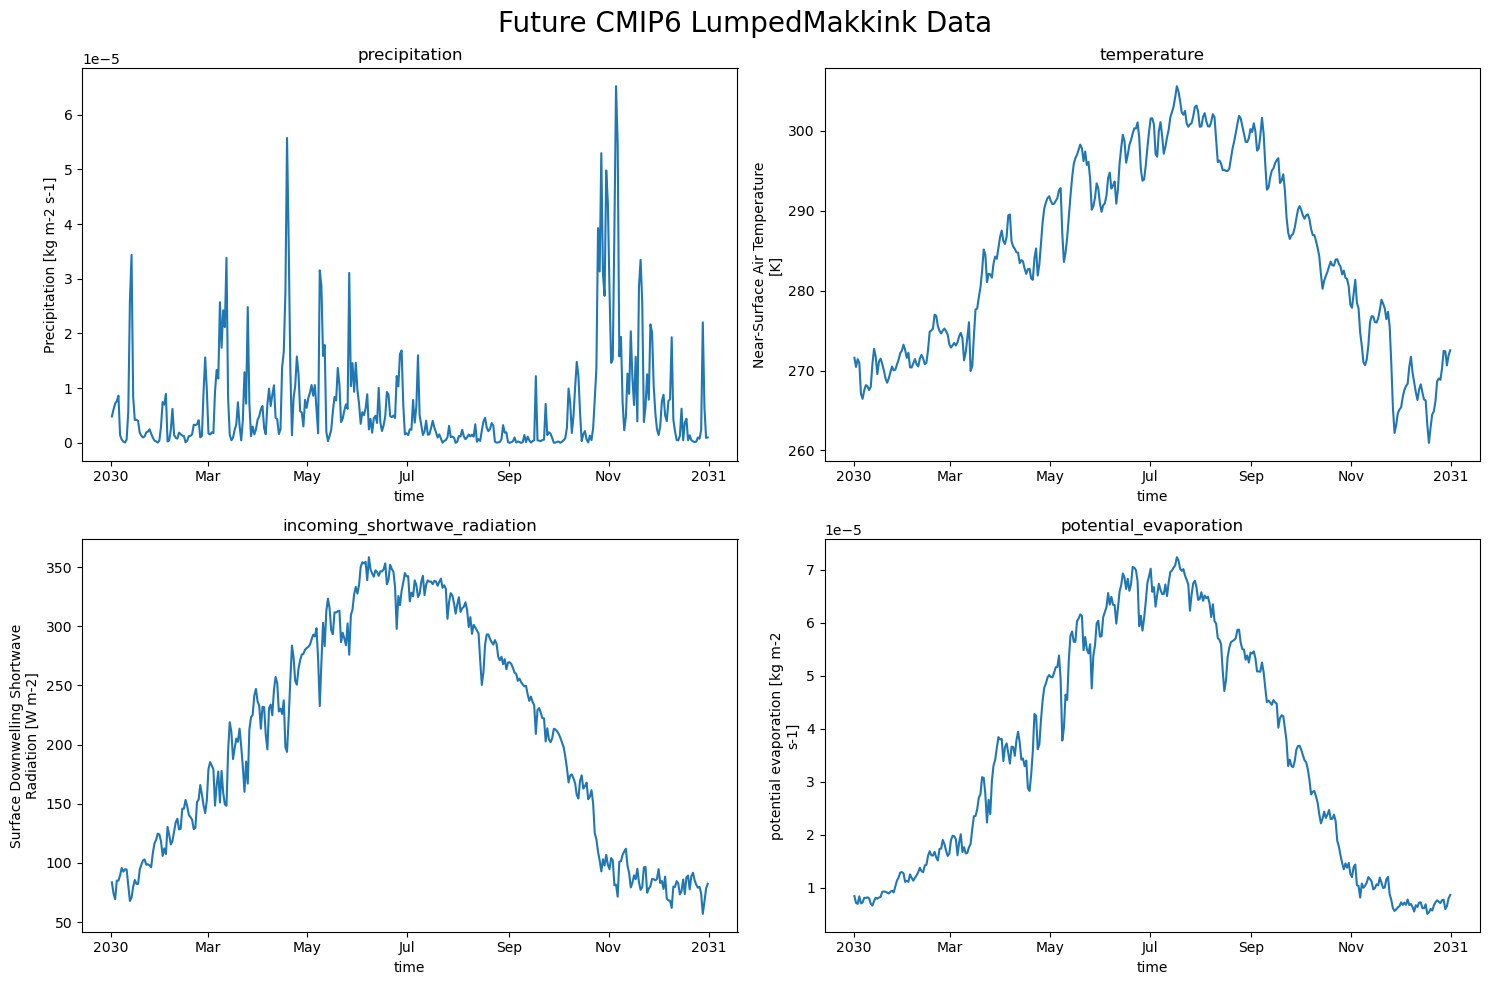

In [46]:
future_data = {'precipitation pr': xr.open_dataset(future_CMIP_forcing['pr']),
             'temperature tas': xr.open_dataset(future_CMIP_forcing['tas']),
             'incoming_shortwave_radiation rsds': xr.open_dataset(future_CMIP_forcing['rsds']),
             'potential_evaporation evspsblpot': xr.open_dataset(future_CMIP_forcing['evspsblpot'])
}

plot_counter = 1
plt.figure(figsize=(15, 10))
for name, data in future_data.items():
    plt.subplot(2,2, plot_counter)
    data[name.split(" ")[-1]].plot()
    plt.title(f"{name.split(" ")[0]}")
    plot_counter += 1

plt.suptitle("Future CMIP6 LumpedMakkink Data", fontsize=20)
plt.tight_layout()

In [47]:
esmvaltool_padding = 2

pcrglobwb_forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].generate(
    dataset= cmip_dataset,
    start_time=experiment_start_date,
    end_time=experiment_end_date,
    start_time_climatology="2030-01-01T00:00:00Z",
    end_time_climatology="2030-12-31T00:00:00Z",
    shape=shapefile_path,
    extract_region={
    "start_longitude": 53-esmvaltool_padding,
    "end_longitude": 80+esmvaltool_padding,
    "start_latitude": 34-esmvaltool_padding,
    "end_latitude": 52+esmvaltool_padding,},
    directory = forcing_path_CMIP / "future" / "PCRGlobWB"

)



In [48]:
ds_1 = xr.load_dataset('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_CMIP_1010/AralSeaBasin/CMIP6/future/PCRGlobWB/work/diagnostic/script/pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_tas_gr_2030-2030_AralSeaBasin.nc')

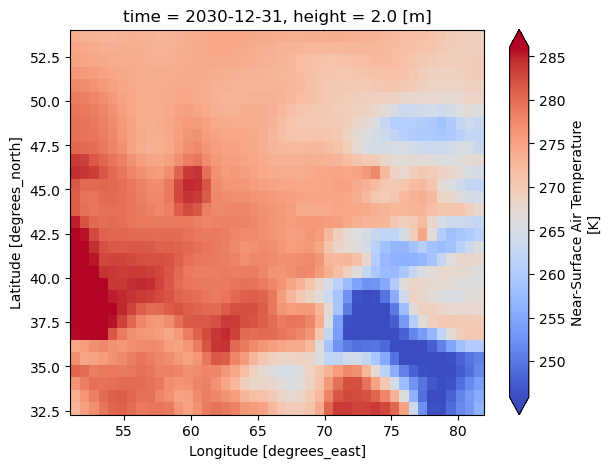

In [49]:
# get the first variable name
first_var = list(ds_1.data_vars)[0]

# select that variable and last timestep
da_1 = ds_1[first_var].isel(time=-1)


#da_1 = ds_1[0].isel(time =-1)


da_1.plot(cmap="coolwarm", robust=True, size=5)

#plt.title(str(da["valid_time"].values))  # extract timestamp from coords
#plt.savefig('ERA5_pr_1988-12-22_21UTC.png')
plt.show()

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 730, lat: 31, lon: 44, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2029-01-01 2029-01-02 ... 2030-12-31
  * lat        (lat) float32 124B 53.69 52.98 52.28 51.58 ... 34.04 33.33 32.63
  * lon        (lon) float32 176B 51.33 52.03 52.74 53.44 ... 80.16 80.86 81.56
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 4MB 266.4 266.7 267.1 ... 253.2 256.4
    time_bnds  (time, bnds) datetime64[ns] 12kB 2028-12-31T12:00:00 ... 2030-...
    lat_bnds   (lat, bnds) float32 248B 54.03 53.33 53.33 ... 32.98 32.98 32.28
    lon_bnds   (lon, bnds) float32 352B 50.98 51.68 51.68 ... 81.21 81.21 81.91
Attributes: (12/45)
    Conventions:            CF-1.7
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time:            0.0
    branch_time_in_child:   60265.0D
    branch_time_in_parent:  60265.0D
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(24 July 2019) MD5:70649eeb16bc90c4...
    title:                  EC-Earth3 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    caption:                Forcings for the PCR-GLOBWB hydrological model.

------------------------

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 730, lat: 31, lon: 44, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 6kB 2029-01-01 2029-01-02 ... 2030-12-31
  * lat        (lat) float32 124B 53.69 52.98 52.28 51.58 ... 34.04 33.33 32.63
  * lon        (lon) float32 176B 51.33 52.03 52.74 53.44 ... 80.16 80.86 81.56
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 4MB 0.0002421 0.0002696 ... 4.224e-06
    time_bnds  (time, bnds) datetime64[ns] 12kB 2028-12-31T12:00:00 ... 2030-...
    lat_bnds   (lat, bnds) float32 248B 54.03 53.33 53.33 ... 32.98 32.98 32.28
    lon_bnds   (lon, bnds) float32 352B 50.98 51.68 51.68 ... 81.21 81.21 81.91
Attributes: (12/45)
    Conventions:            CF-1.7
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time:            0.0
    branch_time_in_child:   60265.0D
    branch_time_in_parent:  60265.0D
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(24 July 2019) MD5:70649eeb16bc90c4...
    title:                  EC-Earth3 output prepared for CMIP6
    variable_id:            pr
    variant_label:          r1i1p1f1
    caption:                Forcings for the PCR-GLOBWB hydrological model.

------------------------

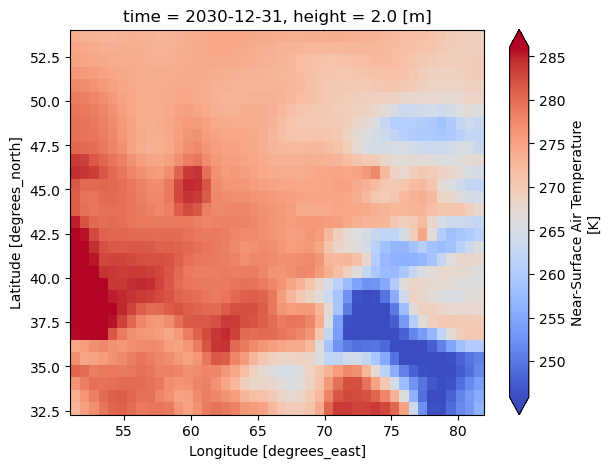

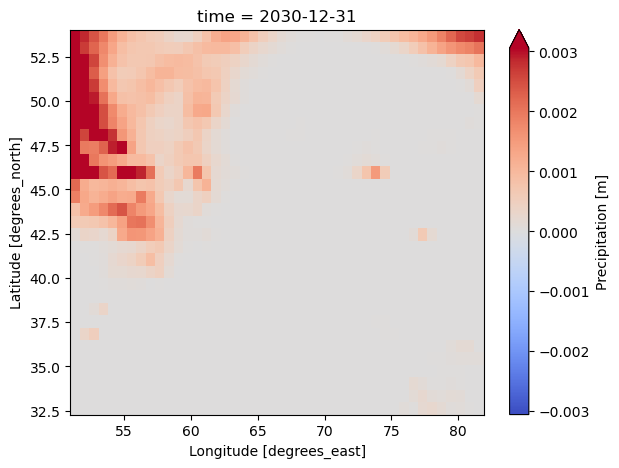

In [50]:
for file_name in [pcrglobwb_forcing.temperatureNC, pcrglobwb_forcing.precipitationNC]:
    dataset = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
    print(dataset)
    print("------------------------")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)

In [51]:
ERA5_forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_progress/Test_Aral/forcing_1010/AralSeaBasin/pcrglobwb/work/diagnostic/script",
)
print(ERA5_forcing)

PCRGlobWBForcing(
    start_time='2010-09-01T00:00:00Z',
    end_time='2010-12-31T00:00:00Z',
    directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_1010/AralSeaBasin/pcrglobwb/work/diagnostic/script'),
    shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_pro
gress/Test_Aral/forcing_1010/AralSeaBasin/pcrglobwb/work/diagnostic/script/AralSeaBasin.shp'),
    filenames={},
    precipitationNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_pr_2010-2010_AralSeaBasin.nc',
    temperatureNC='pcrglobwb_OBS6_ERA5_reanaly_1_day_tas_2010-2010_AralSeaBasin.nc'
)

In [52]:

# import xesmf as xe

# def regrid_to_target(src_file, tgt_file, out_file, method="bilinear"):
#     # load source and target datasets
#     src = xr.load_dataset(src_file)
#     tgt = xr.load_dataset(tgt_file)

#     # choose only variables with lat/lon grid
#     vars_to_regrid = [v for v in src.data_vars if {"lat", "lon"} <= set(src[v].dims)]

#     # create regridder
#     regridder = xe.Regridder(src, tgt, method, extrap_method="nearest_s2d", reuse_weights=False)

#     # regrid all selected variables
#     out_vars = {v: regridder(src[v]) for v in vars_to_regrid}
#     for v in out_vars:
#         out_vars[v].attrs.update(src[v].attrs)

#     # new dataset: use target grid but your regridded variables
#     out = xr.Dataset(out_vars, coords=tgt.coords, attrs=src.attrs)
#     out.to_netcdf(out_file)
#     return out

# # --- regrid temperature ---
# temp_file = f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.temperatureNC}"
# temp_tgt  = f"{ERA5_forcing.directory}/{ERA5_forcing.temperatureNC}"
# regrid_to_target(temp_file, temp_tgt, temp_file)

# # --- regrid precipitation ---
# prec_file = f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.precipitationNC}"
# prec_tgt  = f"{ERA5_forcing.directory}/{ERA5_forcing.precipitationNC}"
# regrid_to_target(prec_file, prec_tgt, prec_file)

# # --- quick check ---
# for file_name in [pcrglobwb_forcing.temperatureNC, pcrglobwb_forcing.precipitationNC]:
#     ds = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
#     print(ds)
#     print("------------------------")
#     var = list(ds.data_vars.keys())[0]
#     ds[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)


In [53]:
import xesmf as xe

# load your source and target datasets
precipitation_dataset = xr.load_dataset(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.precipitationNC}"
)
precipitation_target = xr.load_dataset(
    f"{ERA5_forcing.directory}/{ERA5_forcing.precipitationNC}"
)

# load your source and target datasets
temperature_dataset = xr.load_dataset(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.temperatureNC}"
)
temperature_target = xr.load_dataset(
    f"{ERA5_forcing.directory}/{ERA5_forcing.temperatureNC}"
)






# create a regridder (bilinear interpolation here, change method if needed)
regridder_pr = xe.Regridder(
    precipitation_dataset, 
    precipitation_target, 
    "bilinear",
    extrap_method="nearest_s2d"   # or "nearest_d2s", "inverse_dist"
)

# create a regridder (bilinear interpolation here, change method if needed)
regridder_tas = xe.Regridder(
    temperature_dataset, 
    temperature_target, 
    "bilinear",
    extrap_method="nearest_s2d"   # or "nearest_d2s", "inverse_dist"
)



# apply regridding
precipitation_regridded = regridder_pr(precipitation_dataset)
temperature_regridded = regridder_tas(temperature_dataset) 


# save result
precipitation_regridded.to_netcdf(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.precipitationNC}"
)

temperature_regridded.to_netcdf(
    f"{pcrglobwb_forcing.directory}/{pcrglobwb_forcing.temperatureNC}"
)

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 730, lat: 89, lon: 125)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2029-01-01 2029-01-02 ... 2030-12-31
  * lat      (lat) float32 356B 54.0 53.75 53.5 53.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 500B 51.0 51.25 51.5 51.75 ... 81.25 81.5 81.75 82.0
Data variables:
    pr       (time, lat, lon) float32 32MB 0.0002421 0.0002421 ... 4.224e-06
Attributes:
    regrid_method:  bilinear

------------------------

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 730, lat: 89, lon: 125)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2029-01-01 2029-01-02 ... 2030-12-31
    height   float64 8B 2.0
  * lat      (lat) float32 356B 54.0 53.75 53.5 53.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 500B 51.0 51.25 51.5 51.75 ... 81.25 81.5 81.75 82.0
Data variables:
    tas      (time, lat, lon) float32 32MB 266.4 266.4 266.4 ... 256.4 256.4
Attributes:
    regrid_method:  bilinear

------------------------

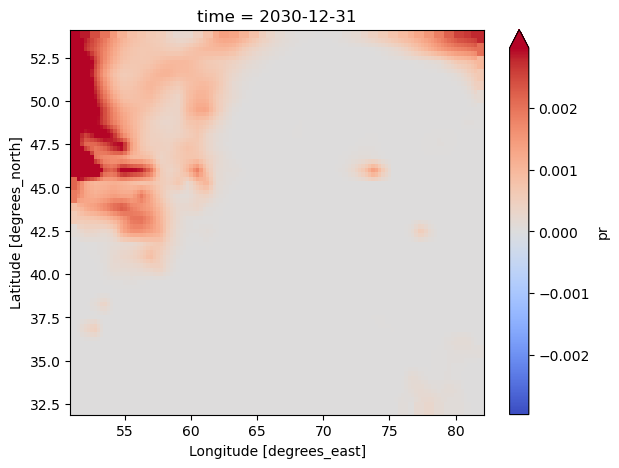

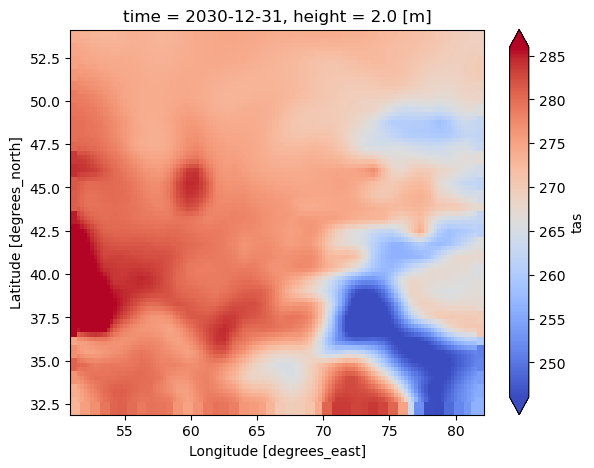

In [54]:
for file_name in [pcrglobwb_forcing.precipitationNC, pcrglobwb_forcing.temperatureNC]:
    dataset = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
    print(dataset)
    print("------------------------")
    var = list(dataset.data_vars.keys())[0]
    dataset[var].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)

In [55]:
print(pcrglobwb_forcing.temperatureNC)

pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_tas_gr_2030-2030_AralSeaBasin.nc

In [56]:
print(pcrglobwb_forcing.precipitationNC)

pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_pr_gr_2030-2030_AralSeaBasin.nc

In [57]:
print(pcrglobwb_forcing)

PCRGlobWBForcing(
    start_time='2030-01-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in
_progress/Test_Aral/forcing_CMIP_1010/AralSeaBasin/CMIP6/future/PCRGlobWB/work/diagnostic/script'),
    shape=PosixPath('/home/avandervee3/MSc_AralSea/book/thesis_projects/MSc/2025_Q1_AndreVanDerVeen_CEG/work_in_pro
gress/Test_Aral/AralSea_Basin/AralSeaBasin.shp'),
    filenames={},
    precipitationNC='pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_pr_gr_2030-2030_AralSeaBasin.nc',
    temperatureNC='pcrglobwb_CMIP6_EC-Earth3_day_ssp585_r1i1p1f1_tas_gr_2030-2030_AralSeaBasin.nc'
)

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 730, lat: 89, lon: 125)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2029-01-01 2029-01-02 ... 2030-12-31
  * lat      (lat) float32 356B 54.0 53.75 53.5 53.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 500B 51.0 51.25 51.5 51.75 ... 81.25 81.5 81.75 82.0
Data variables:
    pr       (time, lat, lon) float32 32MB 0.0002421 0.0002421 ... 4.224e-06
Attributes:
    regrid_method:  bilinear

------------------------

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 730, lat: 89, lon: 125)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2029-01-01 2029-01-02 ... 2030-12-31
    height   float64 8B 2.0
  * lat      (lat) float32 356B 54.0 53.75 53.5 53.25 ... 32.75 32.5 32.25 32.0
  * lon      (lon) float32 500B 51.0 51.25 51.5 51.75 ... 81.25 81.5 81.75 82.0
Data variables:
    tas      (time, lat, lon) float32 32MB 266.4 266.4 266.4 ... 256.4 256.4
Attributes:
    regrid_method:  bilinear

------------------------

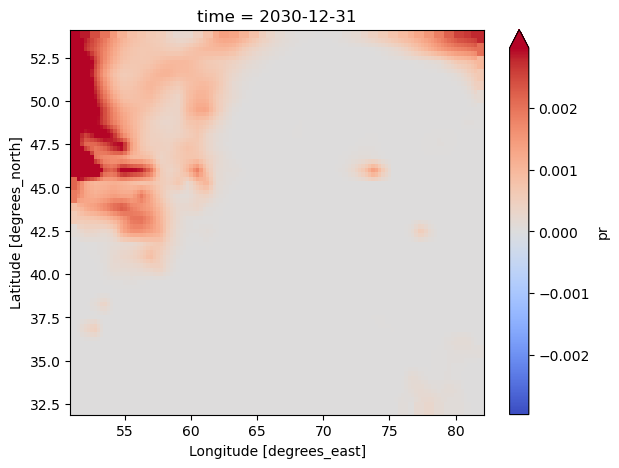

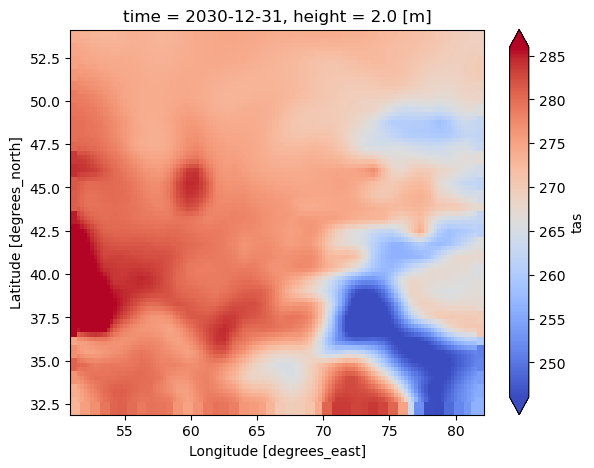

In [58]:
file_var_map = {
    pcrglobwb_forcing.precipitationNC: "pr",
    pcrglobwb_forcing.temperatureNC: "tas",   # or "t2m", depending on your file
}

for file_name, var_name in file_var_map.items():
    ds = xr.load_dataset(f"{pcrglobwb_forcing.directory}/{file_name}")
    print(ds)
    print("------------------------")
    ds[var_name].isel(time=-1).plot(cmap="coolwarm", robust=True, size=5)